**IMPORTS**

In [87]:
import os
import math
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import joblib
from scipy.signal import hilbert, butter, lfilter
import soundfile as sf

**RUTAS Y TIPOS DE FRUTAS**

In [88]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']
dataset_path     = '../../dataset/audios'
original_path    = os.path.join(dataset_path, 'original')
processed_path   = os.path.join(dataset_path, 'processed')
o_tests_path     = os.path.join(original_path, 'tests')
p_tests_path     = os.path.join(processed_path, 'tests')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features'])

**ORIGINAL TESTS**

In [89]:
o_tests = []
o_tests.extend([os.path.join(o_tests_path, filename) for filename in os.listdir(o_tests_path) if filename.endswith('.wav')])

**PROCESSED TESTS DICT**

In [90]:
p_tests = []
p_tests.extend([os.path.join(p_tests_path, filename) for filename in os.listdir(p_tests_path) if filename.endswith('.wav')])

**PARAMETROS DEL AUDIO**

In [91]:
FRAME_SIZE = 1024# In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

**FUNCIONES GENERALES DE AUDIO**

In [92]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [93]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [94]:
def rms(signal, frames, hop):
    return librosa.feature.rms(y=signal, frame_length = frames, hop_length = hop)

In [95]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal

In [96]:
def derivative(signal, duration):
    signal = signal.reshape(-1,)
    dy = np.gradient(signal, np.linspace(0, duration, len(signal)))
    return dy

**FILTERS**

In [97]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [98]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [99]:
def preemphasis(signal, coef=0.97):
    return np.append(signal[0], signal[1:] - coef * signal[:-1])

In [100]:
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

In [101]:
def smooth_envelope(signal, sr, cutoff_frequency=50.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)

**PROCCESSING OF THE AUDIO FILES FUNCTIONS**

In [102]:
def process(audio_in, audio_out, umbral = 0.295):
    signal, sr, duration = load_audio(audio_in)
    
    filtered = low_pass_filter(signal, sr, 1800)
    filtered = preemphasis(filtered, 0.999)

    rms_signal = rms(signal, 4096, 2048)

    rms_signal = normalize(rms_signal)
    drms = normalize(derivative(rms_signal, duration))

    audio_vector = time_vector(signal, duration)
    drms_vector = time_vector(drms, duration)

    left_index = np.argmax(np.abs(drms) > umbral)
    rigth_index = len(drms) - 1 - np.argmax(np.abs(np.flip(drms)) > umbral)

    left_time = drms_vector[left_index]
    rigth_time = drms_vector[rigth_index]

    mask_vector = audio_vector >= left_time

    audio_vector = audio_vector[mask_vector]
    trimed_signal = signal[mask_vector]

    mask_vector = audio_vector <= rigth_time

    audio_vector = audio_vector[mask_vector]
    trimed_signal = trimed_signal[mask_vector]

    sf.write(audio_out, trimed_signal, sr)

**KNN**

In [103]:
def knn(training, test, k_n):
    X = np.concatenate([v for v in training.values()], axis = 0)
    y = np.concatenate([[k] * v.shape[0] for k, v in training.items()])

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear clasificador KNN
    knn_classifier = KNeighborsClassifier(n_neighbors = k_n)

    # Entrenar el clasificador
    knn_classifier.fit(X, y)

    # Predecir las etiquetas para los datos de prueba
    predicted_fruit = knn_classifier.predict(test)

    print(f'La fruta predicha para el nuevo audio es: {predicted_fruit}')

**PLOTTING**

In [104]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [105]:
#3d
def plot_features3d(features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))

    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

In [106]:
#3d
def plot_features3d_extra(features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = dict(zip(features.keys(),['green','yellow','red','orange','cyan']))

    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

**FEATURES EXTRACTION**

*Features extraction function*

In [107]:
def get_features(signal, sr, duration):
    split_frequency = 3000
    cuton = 20
    cutoff = 8500
    n_mfcc = 4
    feature = np.empty((1, 0))

    # Envelope RMS
    smoothed = rms(signal, FRAME_SIZE, HOP_SIZE)
    smoothed = smoothed.reshape(-1,)
    smoothed /= np.max(np.abs(smoothed))
    #std
    feat = np.std(np.abs(smoothed))/np.mean(np.abs(smoothed))
    feature = np.append(feature, feat)

    #ZCR
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    #maximum
    feat = np.max(zcr[((len(zcr)*4)//5 - 5) : ((len(zcr)*4)//5 + 5)])
    feature = np.append(feature, feat)
    zcr /= np.max(np.abs(zcr))
    #mean
    feat = np.mean(zcr[((len(zcr)*2)//7 - 5) : ((len(zcr)*2)//7 + 5)])
    feature = np.append(feature, feat)
    #std
    feat = np.std(zcr)/np.mean(zcr)
    feature = np.append(feature, feat)

    #MFCCS
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    #maximum
    feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[3]
    feature = np.append(feature, feat)
            
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

    #std
    feat = np.std(mfccs, axis = 1)/np.mean(mfccs, axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)

    #momentum
    frames = range(mfccs.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
    feat = feat[0]
    feature = np.append(feature, feat)
    feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)

    #hilbert envelope
    env = smooth_envelope(signal, sr, 45)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    env = env.reshape(-1,1)
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature

**PREDICTION TEST**

*Process tests*

In [108]:
already_processed = [os.path.basename(audio) for audio in p_tests]
for test in o_tests:
    basename =  os.path.basename(test)
    if basename in already_processed:
        pass
    else:
        audio_out = os.path.join(p_tests_path, basename)
        process(test, audio_out, 0.1955)
        p_tests.append(audio_out)

*Extract features*

In [109]:
tests_features = None
for test in p_tests:
    signal, sr, duration = load_audio(test)
    feature = get_features(signal, sr, duration)
    
    if tests_features is not None:
        tests_features = np.vstack([tests_features, feature])
    else:
        tests_features = feature

C:\Users\Juan\AppData\Local\Temp\ipykernel_7788\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


*Load de reduced model*

In [110]:
model = joblib.load(model_file)
reduced = model['features']
pca = model['pca']

*Transform*

In [111]:
reduced_tests = pca.transform(tests_features)

*Extension of the feature dict*

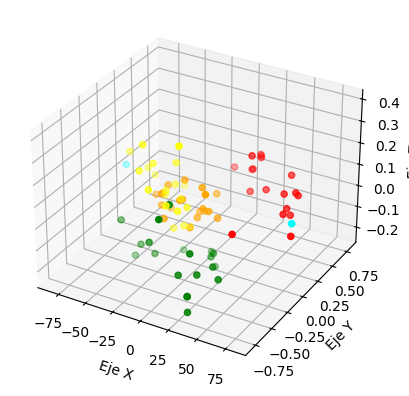

In [112]:
extra = reduced
extra['tests'] = reduced_tests
plot_features3d_extra(extra)

*Prediction*

In [113]:
knn(reduced, reduced_tests, 2)

La fruta predicha para el nuevo audio es: ['naranja' 'manzana']
